In [1]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D , Activation
from keras.utils import np_utils
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2

from skimage.io import imread
from scipy.misc import imresize
from skimage.util import invert

import numpy as np

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

img_rows, img_cols = 128, 128
input_shape = (img_rows, img_cols, 3)

Using TensorFlow backend.


[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13578939967489217491
]


In [2]:
from os.path import join
from numpy import zeros, array

def read_csv(filename):
    res = {}
    with open(filename) as fhandle:
        next(fhandle)
        for line in fhandle:
            parts = line.rstrip('\n').split(',')
            coords = array([float(x) for x in parts[1:]], dtype='float64')
            res[parts[0]] = coords
    return res

train_dir = '/home/tamerlan/CV/task4/tests/00_input/train'
train_gt = read_csv(join(train_dir, 'gt.csv'))
train_img_dir = join(train_dir, 'images')

In [ ]:
def read_img_shapes(gt_dir):
        img_shapes = {}
        with open(join(gt_dir, 'img_shapes.csv')) as fhandle:
            next(fhandle)
            for line in fhandle:
                parts = line.rstrip('\n').split(',')
                filename = parts[0]
                n_rows, n_cols = map(int, parts[1:])
                img_shapes[filename] = (n_rows, n_cols)
        return img_shapes
    
img_shapes = read_img_shapes('/home/tamerlan/CV/task4/tests/00_gt/')

l = np.asarray(list(img_shapes.values()))
np.median(l)

170.0

In [ ]:

filenames = list(train_gt.keys())
data = zeros((len(filenames), 128, 128,3))
for i in range(0, len(train_gt.keys())):
        filename = join(train_img_dir, filenames[i])
        pict = imread(filename)
        if len(pict.shape)==2:
            temp_pict = zeros((pict.shape[0],pict.shape[1],3))
            temp_pict[...,0] = pict
            temp_pict[...,1] = pict
            temp_pict[...,2] = pict
            pict = temp_pict
        pict = imresize(pict , (128, 128), interp = 'bicubic')
        data[i, :] = pict

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(data[0])
plt.show()

In [ ]:
coords = np.asarray(list(img_shapes.values()))
y = np.asarray(list(train_gt.values()))
for i in range(0, len(train_gt.keys())):
    kx = 128./coords[i][1]
    ky = 128./coords[i][0]
    y[i][np.array([0,2,4,6,8,10,12,14,16,18,20,22,24,26])] = kx*y[i][np.array([0,2,4,6,8,10,12,14,16,18,20,22,24,26])] 
    y[i][np.array([1,3,5,7,9,11,13,15,17,19,21,23,25,27])] = ky*y[i][np.array([1,3,5,7,9,11,13,15,17,19,21,23,25,27])] 


In [ ]:
img_rows, img_cols = 128, 128


input_shape = (img_rows, img_cols, 3)

data = data.reshape(data.shape[0], img_rows, img_cols, 3)
#data = data.astype('float32')
#data /= 255

In [ ]:
import random 
from scipy.misc import imrotate
from math import cos,sin
from keras.preprocessing import image

def yagenerator(folder, gt, batch_size):
    h, w = 128, 128
    names = list(gt.keys())
    num = len(names)
    #x = np.empty((batch_size, img_rows, img_cols, 3))
    #y = np.empty((batch_size, 28))
    
    while(True):
        random.shuffle(names)
        for i in range(num // batch_size - 1):
            x = np.empty((batch_size, img_rows, img_cols, 3))
            y = np.empty((batch_size, 28))
            
            for j in range(batch_size):
                ind = i * batch_size + j
                name = names[ind]
                #img = imread(join(folder, names[i]))
                img = image.load_img(join(folder, name))
                img = image.img_to_array(img)
                hr = h / img.shape[0]
                wr = w / img.shape[1]
                img = imresize(img, (h, w), interp='bilinear')
                x[j] = img
                 
                y[j] = gt[name].copy()
                for k in range(14):
                    y[j, 2 * k] = y[j, 2 * k] * wr
                    y[j, 2 * k + 1] = y[j, 2 * k + 1] * hr
            yield (x, y)

def flip(image, coords):
    def swap(coords, i, j):
        temp = coords[2*i: 2*i + 2].copy()
        coords[2*i: 2*i + 2] = coords[2*j: 2*j + 2].copy()
        coords[2*j: 2*j + 2] = temp
        return
    x_coords = np.array([0,2,4,6,8,10,12,14,16,18,20,22,24,26])
    image = np.fliplr(np.array(image))
    coords = np.array(coords)
    coords[x_coords] = image.shape[1] - coords[x_coords]
    swap(coords,0,3)
    swap(coords,1,2)
    swap(coords,4,9)
    swap(coords,5,8)
    swap(coords,6,7)
    swap(coords,11,13)
    return image, coords

def rotate(image, coords):
    angle = random.uniform(-13.0,13.0)
    matrix = np.array([[cos(angle*np.pi/180), sin(angle*np.pi/180)] ,
                       [-sin(angle*np.pi/180), cos(angle*np.pi/180)]])
    coords = np.array(coords)
    for i in range(0,14):
        coords[2*i: 2*i+2] = coords[2*i: 2*i+2] - [image.shape[1] / 2., image.shape[0] / 2.]
        coords[2*i: 2*i+2] = matrix.dot(coords[2*i: 2*i+2])
        coords[2*i: 2*i+2] = coords[2*i: 2*i+2] + [image.shape[1] / 2., image.shape[0] / 2.]
    image = imrotate(np.array(image), angle)
    return image, coords

def crop(image, coords):
    image = np.array(image)
    coords = coords.copy()
    from_x = int(image.shape[1]*0.075)
    to_x = image.shape[1] - from_x
    
    from_y = int(image.shape[0]*0.075)
    to_y = image.shape[0] - from_y
    
    x_coords = np.array([0,2,4,6,8,10,12,14,16,18,20,22,24,26])
    y_coords = np.array([1,3,5,7,9,11,13,15,17,19,21,23,25,27])
    
    probability = random.randint(3,5)
    if probability==0:
        image = image[from_y:,from_x:,: ] 
        coords[x_coords] = coords[x_coords] - from_x
        coords[y_coords] = coords[y_coords] - from_y
    elif probability==1:
        image = image[:,from_x:,: ] 
        coords[x_coords] = coords[x_coords] - from_x
    elif probability==2:
        image = image[from_y: ,: ] 
        coords[y_coords] = coords[y_coords] - from_y
    elif probability==3:
        image = image[ :to_y, : ] 
    elif probability==4:
        image = image[ : , :to_x, ] 
    else :
        image = image[:to_y, :to_x, ]
    #print(probability)    
    return image, coords

def from_path_generator(path_features, labels_csv, batch_size, sample_size):
    img_rows, img_cols = 128, 128
    
    filenames = list(labels_csv.keys())
    labels = np.array(np.asarray(list(labels_csv.values())))
    
    x_coords = np.array([0,2,4,6,8,10,12,14,16,18,20,22,24,26])
    y_coords = np.array([1,3,5,7,9,11,13,15,17,19,21,23,25,27])
    
    # random indexes for each epoch get  diff batchs
    iterator = 0 
    indexes = np.arange(sample_size)
    #np.random.shuffle(indexes)
    while True:
        np.random.shuffle(indexes)
        for iterator in range(sample_size//batch_size):
            batch_features = np.zeros((batch_size, img_rows, img_cols, 3))
            batch_labels = np.zeros((batch_size,28))
            for i in range(0,batch_size):
                # read picture
                filename = join(train_img_dir, filenames[indexes[(i+iterator*batch_size)%sample_size]])
                img = image.load_img(filename)
                pict = image.img_to_array(img)
                coords = labels[indexes[(i+iterator*batch_size)%sample_size]].copy()
                
                probability = random.randint(0,1)
                if probability == 9:
                    pict, coords = flip(pict, coords)
                    
                #coords[x_coords] = coords[x_coords] * 128.0 / pict.shape[1]
                #coords[y_coords] = coords[y_coords] * 128.0 / pict.shape[0] 
                #pict = imresize(pict , (img_rows, img_cols,3), interp = 'bilinear')
                  
                probability = random.randint(0,1)
                if probability == 9:
                    pict, coords = rotate(pict, coords)
                    
                probability = random.randint(0,1)
                if probability == 9:
                    pict, coords = crop(pict, coords)
                     
                    
                coords[x_coords] = coords[x_coords] * 1.0 / pict.shape[1]
                coords[y_coords] = coords[y_coords] * 1.0 / pict.shape[0] 
                pict = imresize(pict , (img_rows, img_cols,3), interp = 'bilinear')
                
                batch_features[i] = pict
                batch_labels[i] = coords
                
#             mean_img = np.zeros((128,128,3))
#             for img in batch_features:
#                 mean_img = mean_img + img/255
#             batch_features = batch_features - mean_img*255.0/ batch_size
            
            batch_features = batch_features.astype('float32') / 255.0
            yield (batch_features, batch_labels)

In [ ]:
import random 
from scipy.misc import imrotate, imread, imsave, imresize
from math import cos,sin
from keras.preprocessing import image
from os.path import join
import numpy as np


def yagenerator2(path_features, labels_csv, batch_size, sample_size):
    img_rows, img_cols = 128, 128
    
    filenames = list(labels_csv.keys())[:sample_size]
    
    x_coords = np.array([2 * k for k in range(0, 14)])
    y_coords = np.array([2 * k + 1 for k in range(0, 14)])
    
    while True:
        random.shuffle(filenames)
        for iterator in range(sample_size // batch_size):
            batch_features = np.zeros((batch_size, img_rows, img_cols, 3))
            batch_labels = np.zeros((batch_size, 28))
            
            for i in range(0, batch_size):
                # read picture
                filename = join(train_img_dir, filenames[i + iterator * batch_size])
                pict = imread(filename, mode='RGB')
                coords = labels_csv[filenames[i + iterator * batch_size]].copy()
                
                probability = random.randint(0,1)
                if probability == 1:
                    pict, coords = flip(pict, coords)
                
                probability = random.randint(0,1)
                if probability == 1:
                    pict, coords = rotate(pict, coords)
                
                probability = random.randint(0,1)
                if probability == 1:
                    pict, coords = crop(pict, coords)
                     
                    
                coords[x_coords] = coords[x_coords] / pict.shape[1]
                coords[y_coords] = coords[y_coords] / pict.shape[0] 
                pict = imresize(pict, (img_rows, img_cols), interp = 'bilinear')
                
                batch_features[i] = pict
                batch_labels[i] = coords
            
            batch_features = batch_features.astype('float32') / 255.0
            yield (batch_features, batch_labels)

In [ ]:

model = Sequential()
# first set of CONV => RELU => POOL
model.add(Conv2D(32, 5, 5, border_mode="same",
    input_shape=(128,128, 3), dim_ordering='th'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), dim_ordering='th'))
model.add(BatchNormalization())

# second set of CONV => RELU => POOL
model.add(Conv2D(48, 5, 5, border_mode="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), dim_ordering='th'))
model.add(BatchNormalization())

# second set of CONV => RELU => POOL
model.add(Conv2D(64, 5, 5, border_mode="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

# set of FC => RELU layers
model.add(Flatten())
model.add(Dense(500))
model.add(Activation("relu"))
model.add(BatchNormalization())

model.add(Dense(28))

# Компилируем модель
sgd = keras.optimizers.SGD(lr=0.1, clipnorm=1.)
model.compile(loss="mse", optimizer='sgd')

print(model.summary())


model.fit_generator(from_path_generator(train_img_dir, train_gt, batch_size=64, sample_size = 5000),
                    steps_per_epoch=5000//64,
                    epochs=50,
                    verbose=1,
                    validation_data=(data[5000:].astype('float32'), y[5000:]))

In [ ]:

model = Sequential()

#model.add(BatchNormalization(input_shape=(128, 128, 3)))
# first set of CONV => RELU => POOL
model.add(Conv2D(16, (3,3),
    input_shape=(128, 128, 3),activation='relu',padding='same', data_format = 'channels_last'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(BatchNormalization())

# second set of CONV => RELU => POOL
model.add(Conv2D(32, (3, 3),activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(BatchNormalization())

# second set of CONV => RELU => POOL
model.add(Conv2D(64, (3, 3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(BatchNormalization())

model.add(Conv2D(128, (3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(BatchNormalization())

# set of FC => RELU layers
model.add(Flatten())
model.add(Dense(150,activation='relu'))
model.add(Dropout(0.2))
#model.add(BatchNormalization())
#model.add(Dense(84, activation='relu'))
model.add(Dense(28))

# Компилируем модель
sgd = keras.optimizers.SGD(lr=0.01, clipnorm=1.)
model.compile(loss="mse", optimizer='sgd')

In [ ]:
print(model.summary())

sgd = keras.optimizers.SGD(lr=0.0019)
model.optimizer = sgd

optimizer = keras.optimizers.SGD(lr=0.09, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='mse',optimizer=optimizer)

model.fit_generator(from_path_generator(train_img_dir, train_gt, batch_size=32, sample_size = 5000),
                    steps_per_epoch=5000//32,
                    epochs=50,
                    verbose=1,
                    validation_data=(data[5000:].astype('float32')/255, y[5000:]/128))

In [ ]:
model = Sequential()

model.add(Conv2D(24,  kernel_size=(5, 5), 
                 activation='relu', 
                 input_shape=input_shape,
                 data_format = 'channels_last'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(36, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(48, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(84, activation='relu'))

model.add(Dense(28))

sgd = keras.optimizers.SGD(lr=0.1)
model.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])

In [70]:
print(model.summary())

model.fit_generator(from_path_generator(train_img_dir, train_gt, batch_size=96, sample_size= 5000),
                    steps_per_epoch=5000//96,
                    epochs=35,
                    verbose=1,
                    validation_data=(data[5000:].astype('float32')/255., y[5000:]/128))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_68 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 16, 16, 128)       73856     
__________

KeyboardInterrupt: 

In [ ]:
model = Sequential()

model.add(Conv2D(24,  kernel_size=(5, 5), 
                 activation='relu', 
                 input_shape=input_shape,
                 data_format = 'channels_last'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(36, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(84, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(28))

sgd = keras.optimizers.SGD(lr=0.059, momentum=0.8)
model.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])

In [ ]:
print(model.summary())

sgd = keras.optimizers.SGD(lr=0.01, clipnorm = 1.0)
model.optimizer = sgd

model.fit(data,y, batch_size=96, epochs=33,  validation_split=0.2, verbose=1)

In [ ]:
print(model.summary())

sgd = keras.optimizers.SGD(lr=0.029, momentum=0.8)
model.optimizer = sgd

model.fit_generator(yagenerator(train_img_dir, train_gt, batch_size=96),
                    steps_per_epoch=6000//96,
                    epochs=35,
                    verbose=1,
                    validation_data=(data[4800:].astype('float32')/255.0, y[4800:]))

In [ ]:
print(model.summary())

sgd = keras.optimizers.SGD(lr=0.029, momentum=0.8)
model.optimizer = sgd

model.fit_generator(from_path_generator(train_img_dir, train_gt, batch_size=96, sample_size = 4800),
                    steps_per_epoch=4800//96,
                    epochs=35,
                    verbose=1,
                    validation_data=(data[4800:].astype('float32')/255.0, y[4800:]/128.0))

In [2]:
l2_lambda = 0.001

model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3),
                 activation='relu',
                 input_shape=input_shape, 
                 data_format = 'channels_last'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu' ))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(700, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(28))
# Компилируем модель
sgd = keras.optimizers.SGD(lr=0.05)
model.compile(loss="mean_squared_error", optimizer=sgd)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
__________

In [ ]:
print(model.summary())

model.fit(data/255.0,y, batch_size=96, epochs=33,  validation_split=0.2, verbose=1)

In [ ]:
sgd = keras.optimizers.SGD(lr=0.009, momentum=0.8)
model.optimizer = 'adagrad'

print(model.summary())

model.fit(data/255.0,y, batch_size=96, epochs=33,  validation_split=0.2, verbose=1)

In [ ]:
print(model.summary())

#sgd = keras.optimizers.SGD(lr=0.05,clipnorm=1.0, nesterov = True)
#model.compile(loss="mean_squared_error", optimizer=sgd)

model.fit_generator(from_path_generator(train_img_dir, train_gt, batch_size=96, sample_size = 5000),
                    steps_per_epoch=5000//96,
                    epochs=35,
                    verbose=1,
                    validation_data=(data[5000:].astype('float32')/255.0, y[5000:]))

In [ ]:
#model.save("facepoints_model.hdf5")
sgd = keras.optimizers.SGD(lr=0.005, momentum=0.8)
model.optimizer = sgd

In [69]:
import keras.backend as K
#K.set_value(opt.lr, 0.01)
K.get_value(model.optimizer.lr)

0.090000004

In [12]:
from keras.models import load_model

model = load_model( 'facepoints_model.hdf5')

In [46]:
scores = model.evaluate(data[:].astype('float32')/255,y[:]/128, verbose=1)
print(scores)
print("Среднеквадратичное отклонение на тестовых данных: %.5f" % (scores))

6000/6000 [==============================] - 52s    
0.000605882172783
Среднеквадратичное отклонение на тестовых данных: 0.00061


In [ ]:
l2_lambda = 0.001

model = Sequential()

model.add(Conv2D(16, kernel_size=(3,3),
                 activation='relu',
                 input_shape=input_shape, 
                 data_format = 'channels_last'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu' ))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu' ))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())

model.add(Dense(500, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(700, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(28, activation='relu'))
# Компилируем модель
sgd = keras.optimizers.SGD(lr=0.1, nesterov = True)
model.compile(loss="mean_squared_error", optimizer=sgd)

In [ ]:
from keras import backend as K
from keras.callbacks import LearningRateScheduler
import math

decay_rate = []

drop = 0.5
epochs_drop = 1.0
initial_lrate = 0.1

def step_decay(epoch):
    
    # LearningRate = InitialLearningRate * DropRate^floor(Epoch / EpochDrop)
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    
    # Store the decaying learning rate in a list
    decay_rate.append(lrate)
    
    return lrate

def exp_decay(epoch):
    initial_lrate = 0.01
    k = 0.01
    lrate = initial_lrate * math.exp(-k*epoch)
    return lrate

# Initialize Learning Rate Scheduler Callback
lrate = LearningRateScheduler(exp_decay)


print(model.summary())

model.fit_generator(from_path_generator(train_img_dir, train_gt, batch_size=64, sample_size = 5000),
                    steps_per_epoch=5000//64,
                    epochs=40,
                    verbose=1, callbacks = [lrate],
                    validation_data=(data[5000:].astype('float32')/255.0,y[5000:]))

In [47]:
model.save("facepoints_model.hdf5")

In [ ]:
model.save("facepoints_model3.hdf5")

In [ ]:
model.save("facepoints_model128.hdf5")

In [ ]:
model.save("facepoints_model128_batch250.hdf5")

In [ ]:
print(model.summary())

model.fit(data,y, batch_size=96, epochs=33,  validation_split=0.2, verbose=2)

In [18]:
def draw_points(image, coords):
    image = np.array(image)
    for i in range(0,14):
        image[int(coords[2*i+1]),int(coords[2*i]),0] = 1.0
        image[int(coords[2*i+1]),int(coords[2*i]),1] = 0
        image[int(coords[2*i+1]),int(coords[2*i]),2] = 0

        image[int(coords[2*i+1]) + 1,int(coords[2*i]) + 1,0] = 1.0
        image[int(coords[2*i+1]) + 1,int(coords[2*i]) + 1,1] = 0
        image[int(coords[2*i+1]) + 1,int(coords[2*i]) + 1,2] = 0

        image[int(coords[2*i+1])-1,int(coords[2*i])-1,0] = 1.0
        image[int(coords[2*i+1])-1,int(coords[2*i])-1,1] = 0
        image[int(coords[2*i+1])-1,int(coords[2*i])-1,2] = 0

        image[int(coords[2*i+1])+1,int(coords[2*i])-1,0] = 1.0
        image[int(coords[2*i+1])+1,int(coords[2*i])-1,1] = 0
        image[int(coords[2*i+1])+1,int(coords[2*i])-1,2] = 0

        image[int(coords[2*i+1])-1,int(coords[2*i])+1,0] = 1.0
        image[int(coords[2*i+1])-1,int(coords[2*i])+1,1] = 0
        image[int(coords[2*i+1])-1,int(coords[2*i])+1,2] = 0
    return image

In [ ]:
plt.imshow(draw_points(data[0]/255,y[0]))
plt.show()

In [ ]:
n =0
t,c = crop(data[n]/255,y[n])
plt.imshow(draw_points(t,c))
plt.show()

In [ ]:

for batch, labels in from_path_generator(train_img_dir, train_gt, batch_size=100, sample_size = 5000): 
    if True:
        for i in range(batch.shape[0]):
            plt.imshow(draw_points(batch[i],labels[i]*128))
            #plt.imshow(img)
            plt.show()
        print("~~~~~~~~~~end batch~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

In [15]:
temp_im = np.zeros((1,128,128,3))
temp_im[0] = data[0]/255
coords_p = model.predict(data[:100].astype('float32')/255)

In [16]:
print(y[0]/128)
coords_p[0]

[ 0.19465649  0.19465649  0.48473282  0.22900763  0.64503817  0.2480916
  0.77480916  0.19847328  0.25954198  0.29389313  0.32442748  0.28625954
  0.41984733  0.3129771   0.61068702  0.33206107  0.65267176  0.30152672
  0.73664122  0.32061069  0.59541985  0.54961832  0.35114504  0.66412214
  0.53435115  0.6870229   0.64122137  0.68320611]


array([ 0.21202309,  0.20288363,  0.45653394,  0.2066208 ,  0.65417796,
        0.23027222,  0.79081082,  0.22359554,  0.26092455,  0.2788043 ,
        0.32824609,  0.2806569 ,  0.42990756,  0.29612097,  0.62749457,
        0.32180598,  0.68568915,  0.30153352,  0.76827627,  0.32273975,
        0.57363117,  0.54377902,  0.35685012,  0.66161811,  0.53482527,
        0.68188083,  0.64638424,  0.68216926], dtype=float32)

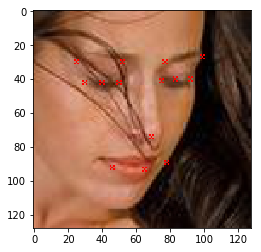

In [21]:
plt.imshow(draw_points(data[9]/255,coords_p[9]*128))
plt.show()

In [ ]:
coords = np.array(y[0]*128)
img = data[0][10:118,:]/255


x_coords = np.array([0,2,4,6,8,10,12,14,16,18,20,22,24,26])
y_coords = np.array([1,3,5,7,9,11,13,15,17,19,21,23,25,27])

coords[y_coords] = (coords[y_coords]-10)

plt.imshow(draw_points(img,coords))
plt.show()
print(img.shape)

In [ ]:
coords[y_coords] = coords[y_coords]*128/img.shape[0]
img = imresize(img,(128,128))
plt.imshow(draw_points(img,coords))
plt.show()

In [ ]:
mean_img = np.zeros((128,128,3))
for img in data:
    mean_img =mean_img + img/255
    
plt.imshow(mean_img/6000)
plt.show()

for batch, labels in from_path_generator(train_img_dir, train_gt, batch_size=96,sample_size=1000):
    for i in range(batch.shape[0]):
            plt.imshow(draw_points(batch[i],labels[i]*128))
            plt.show()

In [ ]:
for batch, labels in from_path_generator(train_img_dir, train_gt, batch_size=96,sample_size=1000): 
    for i in range(batch.shape[0]): 
        plt.imshow(draw_points(batch[i],labels[i]*128)) 
        plt.show()

In [ ]:
x_coords = np.array([2 * k for k in range(0, 14)])
y_coords = np.array([2 * k + 1 for k in range(0, 14)])

In [2]:
def detect(model, test_img_dir):
    #filenames = glob(join(test_img_dir + '/', '*.jpg'))
    #print(filenames)
    filenames = os.listdir(test_img_dir)
    filenames.sort()
    detected_points = {}
    batch_size = 1000
    
    x_coords = np.array([0,2,4,6,8,10,12,14,16,18,20,22,24,26])
    y_coords = np.array([1,3,5,7,9,11,13,15,17,19,21,23,25,27])
    
    for j in range(len(filenames)//batch_size):
        batch_features = np.zeros((batch_size, img_rows, img_cols, 3))
        size_images = np.zeros((batch_size , 2))
        for i in range(0,batch_size):
            # read picture
            filename = filenames[i+j*batch_size]
            img = image.load_img(join(test_img_dir,filename))
            pict = image.img_to_array(img)
            size_images[i][0] = pict.shape[0]
            size_images[i][1] = pict.shape[1]
            
            pict = imresize(pict , (img_rows, img_cols,3), interp = 'bilinear')
            batch_features[i] = pict
        batch_labels = model.predict(batch_features / 255.)
        for i in range(0,batch_size):
            coords = batch_labels[i]
            coords[x_coords] = coords[x_coords] * size_images[i][1]
            coords[y_coords] = coords[y_coords] * size_images[i][0]
            
            filename = filenames[i+j*batch_size]
            detected_points[filename] = coords
    
    if (len(filenames)%batch_size!=0):
        size_excess = len(filenames)%batch_size
        k = len(filenames)//batch_size
        batch_features = np.zeros((size_excess, img_rows, img_cols, 3))
        size_images = np.zeros((size_excess , 2))
        for i in range(0,size_excess):
                # read picture
                filename = filenames[i+k*batch_size]
                img = image.load_img(join(test_img_dir,filename))
                pict = image.img_to_array(img)
                size_images[i][0] = pict.shape[0]
                size_images[i][1] = pict.shape[1]

                pict = imresize(pict , (img_rows, img_cols,3), interp = 'bilinear')
                batch_features[i] = pict
        batch_labels = model.predict(batch_features / 255.)
        for i in range(0,size_excess):
            coords = batch_labels[i]
            coords[x_coords] = coords[x_coords] * size_images[i][1]
            coords[y_coords] = coords[y_coords] * size_images[i][0]

            filename = filenames[i+k*batch_size]
            detected_points[filename] = coords
            
    return detected_points

detected_points = detect(model, '/home/tamerlan/CV/task4/tests/00_input/test/images')

NameError: name 'model' is not defined

In [38]:
len(detected_points)

5999

In [3]:
model = Sequential()

model.add(Conv2D(32,  kernel_size=(3, 3), 
                 activation='relu', 
                 input_shape=(128,128,1),
                 data_format = 'channels_last'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10))

sgd = keras.optimizers.SGD(lr=0.059, momentum=0.8)
model.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
dense_1 (Dense)              (None, 14, 14, 512)       66048     
__________